This ntbk impleement  glbl-feature AE baseline for image-level anomaly detection.

In [2]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

from torchvision.models import resnet50, ResNet50_Weights

In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_image_path = Path('../data/carpet/train')

good_dataset = ImageFolder(root=train_image_path, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])

BS = 16

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BS)


Loaded a pretrained resnet model

In [4]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.eval()
        for p in self.model.parameters():
            p.requires_grad = False

        self.features = []

        def hook(module, input, output):
            self.features.append(output)

        self.model.layer2[-1].register_forward_hook(hook)
        self.model.layer3[-1].register_forward_hook(hook)

        self.avg_pool = nn.AvgPool2d(kernel_size =3, stride=1, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        self.features = []
        with torch.no_grad():
            _ = self.model(x)

        f2, f3 = self.features  # layer2, layer3

        f2 = self.avg_pool(f2)
        f3 = self.avg_pool(f3)

        target_size = f2.shape[-2:]
        f3 = nn.functional.interpolate(f3, size=target_size, mode='bilinear', align_corners=False)

        patch_features = torch.cat([f2, f3], dim=1)  # [B, C, H, W]

        #for baseline model
        global_features = self.gap(patch_features)
        global_features = global_features.view(global_features.size(0), -1)  # [B, C]

        return patch_features, global_features

torch.Size([1, 1536, 28, 28])
torch.Size([1, 1536])


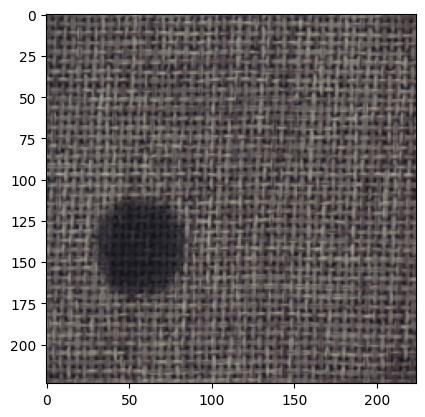

In [5]:
backbone = ResNetFeatureExtractor().cpu()
backbone.eval()


debug_img = Image.open('../data/carpet/test/color/000.png')
debug_img = transform(debug_img).unsqueeze(0)


patch_feat, global_feat = backbone(debug_img)
print(patch_feat.shape)
print(global_feat.shape)

plt.imshow(debug_img[0].permute(1,2,0))

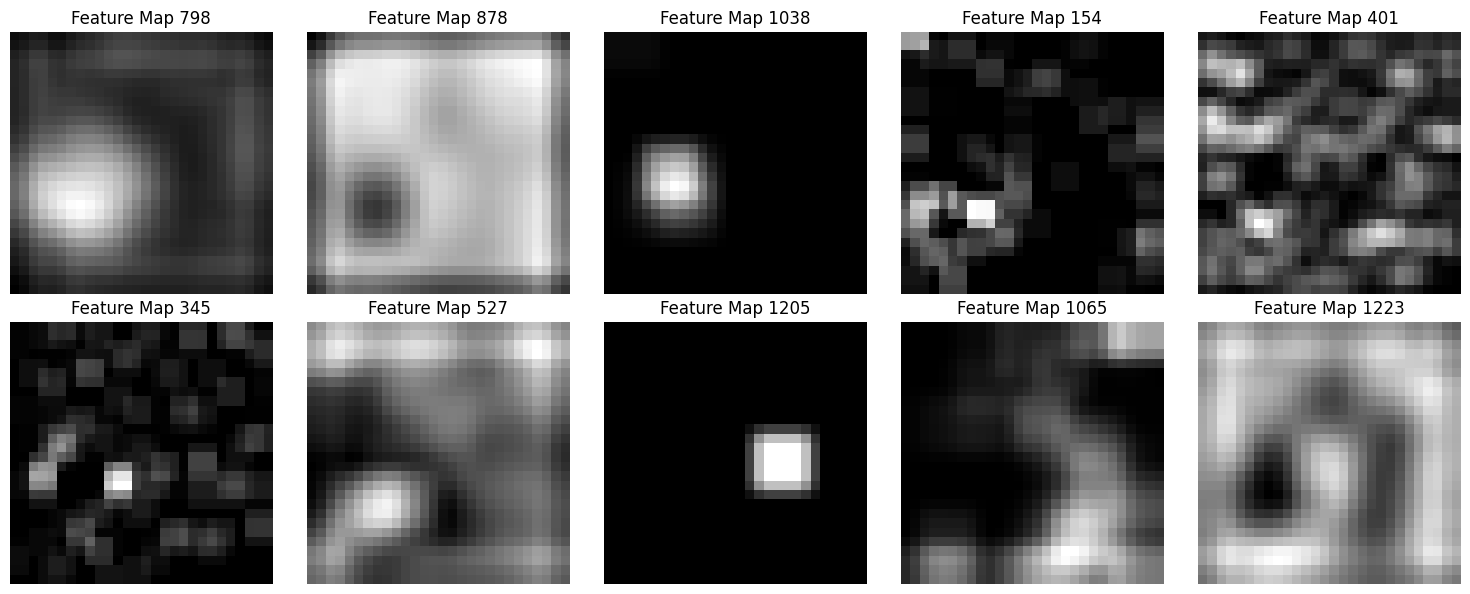

In [8]:
feature = backbone(debug_img)
indices = torch.randperm(feature[0][0].shape[0])[:10]

# Plot the selected feature maps
fig, axes = plt.subplots( 2,5, figsize=(15, 6))
for i, idx in enumerate(indices):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(feature[0][0][idx].detach().cpu(), cmap='gray')
    axes[row, col].set_title(f'Feature Map {idx}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

The baseline simple autoencoder model.

In [9]:
class FeatureAutoEncoder(nn.Module):
    def __init__(self, input_dim=1536, latent_dim=128):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat


In [10]:
print(feature[0].shape)

torch.Size([1, 1536, 28, 28])


In [11]:
model = FeatureAutoEncoder(input_dim=1536,latent_dim=128).cpu()

criterion = torch.nn.MSELoss()  #loss funct
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [12]:
model.eval()

FeatureAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=1536, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1536, bias=True)
  )
)

In [14]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, _ in train_loader:   #only GOOD images
        images = images.cpu()

        with torch.no_grad():
            _ , global_features = backbone(images)
            # global_features: [B, 1536]

        recon = model(global_features)
        loss = criterion(recon, global_features)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_loss:.6f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.cpu()
            _ , global_features = backbone(images)

            recon = model(global_features)
            val_loss += criterion(recon, global_features).item()

    val_loss /= len(test_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Validation Loss: {val_loss:.6f}")


Epoch [1/5] | Train Loss: 0.002542
Epoch [1/5] | Validation Loss: 0.002467
Epoch [2/5] | Train Loss: 0.002525
Epoch [2/5] | Validation Loss: 0.002446
Epoch [3/5] | Train Loss: 0.002544
Epoch [3/5] | Validation Loss: 0.002470
Epoch [4/5] | Train Loss: 0.002548
Epoch [4/5] | Validation Loss: 0.002489
Epoch [5/5] | Train Loss: 0.002563
Epoch [5/5] | Validation Loss: 0.002485


In [ ]:
# Save autoencoder model
torch.save({
    "model_state": model.state_dict(),
    "input_dim": 1536,
    "latent_dim": 128
}, "../checkpoints/carpet_feature_autoencoder.pth")

In [ ]:
#Loading autoencoder model

checkpoint = torch.load("../checkpoints/carpet_feature_autoencoder.pth", map_location="cpu")
model = FeatureAutoEncoder(
    input_dim=checkpoint["input_dim"], 
    latent_dim=checkpoint["latent_dim"]
)
model.load_state_dict(checkpoint["model_state"])
model.eval()


FeatureAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=1536, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1536, bias=True)
  )
)

In [34]:
print(debug_img.shape)

torch.Size([1, 3, 224, 224])


In [20]:
def anomaly_score(image,backbone,model):
    model.eval()
    backbone.eval()

    with torch.no_grad():
        _,global_feat = backbone(image.unsqueeze(0))
        recon=model(global_feat)

        score=torch.mean((global_feat-recon)**2).item()

    return score



In [21]:
normal_scores=[]

for images , _ in train_loader : 
    for img in images : 
        s=anomaly_score(img,backbone,model)
        normal_scores.append(s)

normal_scores=np.array(normal_scores)


In [22]:
test_root = Path("../data/carpet/test")

test_scores =[]
test_labels=[]

for defect_type in os.listdir(test_root):
    defect_path = test_root / defect_type 

    if not defect_path.is_dir():
        continue

    label = 0 if defect_type == 'good' else 1

    for img_name in os.listdir(defect_path):
        img = Image.open(defect_path / img_name)
        img = transform(img)

        score = anomaly_score(img,backbone,model)
        test_scores.append(score)
        test_labels.append(label)

In [23]:
# threshold = normal_scores.mean() + 3 * normal_scores.std()
threshold = np.percentile(normal_scores, 95)


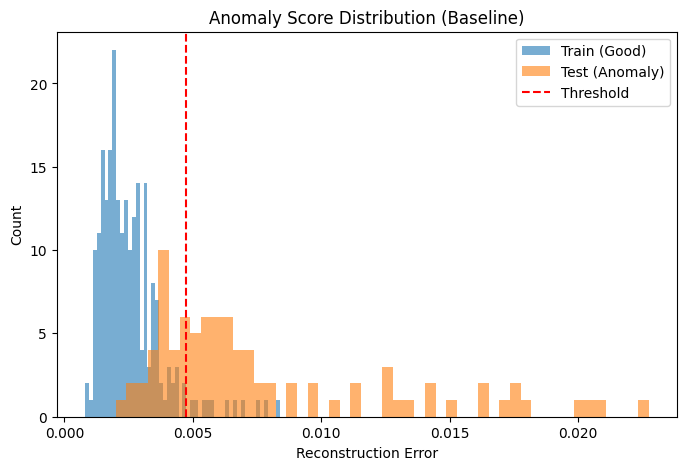

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(normal_scores, bins=50, alpha=0.6, label='Train (Good)')
plt.hist([s for s,l in zip(test_scores, test_labels) if l==1],
         bins=50, alpha=0.6, label='Test (Anomaly)')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title("Anomaly Score Distribution (Baseline)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.show()


Baseline ROC-AUC: 0.517255216693419


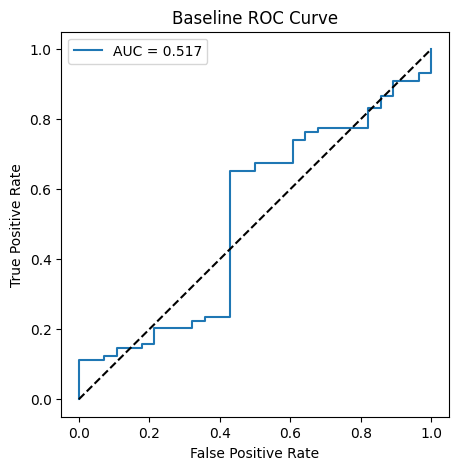

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

roc_auc_val = roc_auc_score(test_labels, test_scores)
print('Baseline ROC-AUC:', roc_auc_val)

fpr, tpr, _ = roc_curve(test_labels, test_scores)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_val:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline ROC Curve')
plt.legend()
plt.show()